# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
  
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>

## <center>Projeto Final</center>

**Nome**: Anne Mari Suenaga Sakai e Felipe Jun Nishitani

**RA**: 822304 e 822353


---
### Análise exploratória

Nesta seção, deve ser feita a leitura da base de dados e todas as análises necessárias para interpretar e analisar os dados, tais como:
* Significado de cada atributo
* Medidas descritivas
* Gráficos

A base contém atributos derivados de sensores vestíveis, representando médias, desvios padrão, máximos e mínimos das medições fisiológicas de cada usuário.  
A variável **classe** indica o tipo de esforço (Stress, Aeróbico ou Anaeróbico).

- Os boxplots revelam a presença de outliers em alguns atributos, sugerindo variações extremas entre sujeitos.  
- A matriz de correlação mostra que certos sensores apresentam relações lineares, indicando possíveis atributos redundantes.  
- As distribuições das classes mostram um conjunto relativamente balanceado entre as categorias.


In [67]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Leitura e resumo inicial
# ==========================================================
from scripts.analise_exploratoria import *

base_path = "dataset"

# Carregar e exibir informações básicas
df = carregar_e_resumir(base_path)



--- Carregando dataset ---

--- Gerando dataset consolidado ---
Dataset com 75 amostras e 8 atributos.

✅ Primeiras linhas:


,Id,classe,TEMP_mean,HR_mean,ACC_mean,IBI_mean,EDA_mean,BVP_mean
0,U_79201,STRESS,34.270396,98.821344,-5.631889,429.356063,2.189811,0.020494
1,U_56491,ANAEROBIC,28.349428,88.201980,2.113240,589.505816,0.695010,0.021553
2,U_94628,ANAEROBIC,33.942008,105.932371,12.135499,671.629473,4.049409,0.009702
3,U_97819,AEROBIC,30.956354,84.796326,-4.079631,681.610579,5.359092,0.029392
4,U_96956,STRESS,31.656112,79.560809,0.241726,717.347185,0.670497,0.001560



📊 Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         75 non-null     object 
 1   classe     75 non-null     object 
 2   TEMP_mean  75 non-null     float64
 3   HR_mean    75 non-null     float64
 4   ACC_mean   75 non-null     float64
 5   IBI_mean   74 non-null     float64
 6   EDA_mean   75 non-null     float64
 7   BVP_mean   75 non-null     float64
dtypes: float64(6), object(2)
memory usage: 4.8+ KB


None


📈 Estatísticas descritivas:


,TEMP_mean,HR_mean,ACC_mean,IBI_mean,EDA_mean,BVP_mean
count,75.000000,75.000000,75.000000,74.000000,75.000000,75.000000
mean,38.686697,94.025314,13.406130,7920.265006,6.680819,0.003332
std,30.820055,16.048698,15.758787,64026.826174,8.233190,0.011656
min,25.293655,62.193177,-26.870162,20.710938,0.238126,-0.032294
25%,31.578436,82.338899,2.159397,327.641624,1.361458,-0.002810
50%,32.555787,93.919418,12.135499,450.104494,3.690940,0.003114
75%,33.672345,105.284238,28.379903,671.659085,8.649052,0.009903
max,211.905950,141.841251,38.691488,551254.077344,41.493190,0.029392



--- Medidas descritivas ---

📦 Distribuição das classes:


ANAEROBIC    28
STRESS       25
AEROBIC      22
Name: classe, dtype: int64

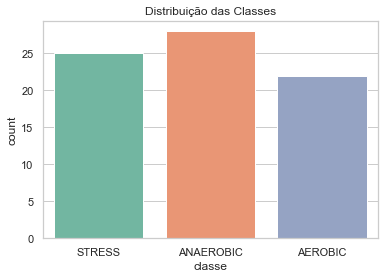


🚨 Valores ausentes por coluna:


Id           0
classe       0
TEMP_mean    0
HR_mean      0
ACC_mean     0
IBI_mean     1
EDA_mean     0
BVP_mean     0
dtype: int64

In [68]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Medidas descritivas
# ==========================================================
medidas_descritivas(df)



--- Boxplots e Histogramas ---


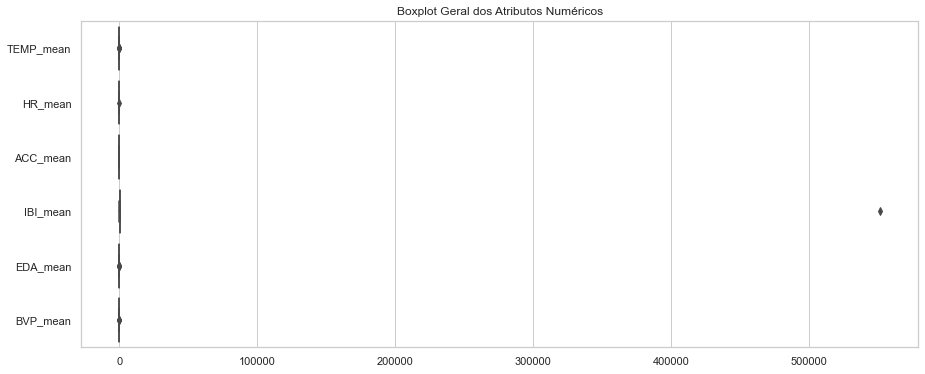

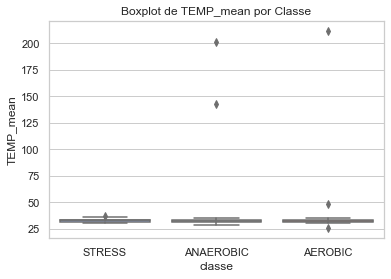

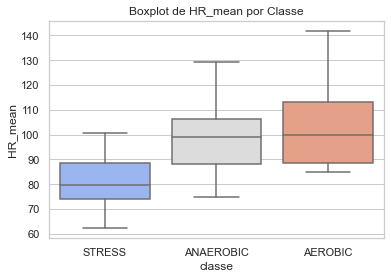

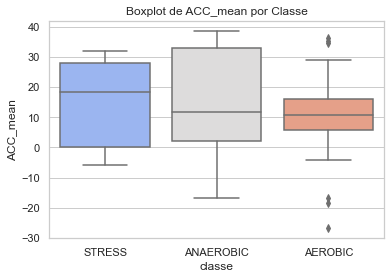

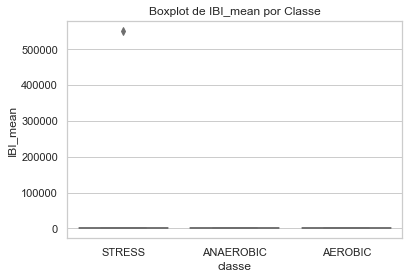

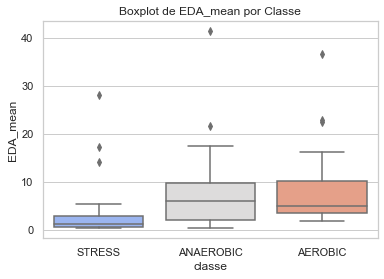

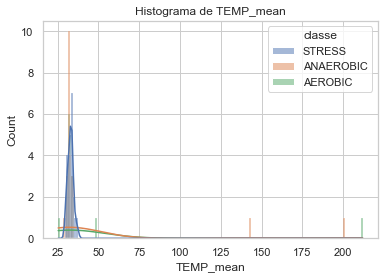

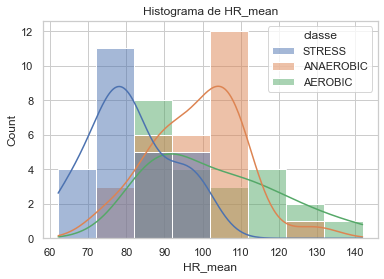

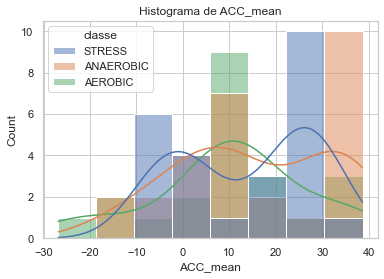

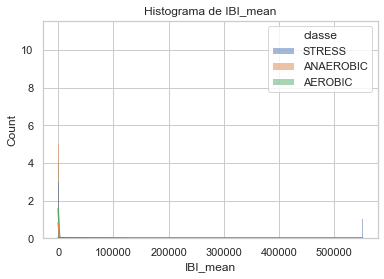

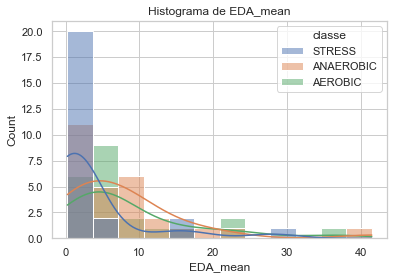

In [69]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Boxplots e Histogramas
# ==========================================================
boxplots_e_histogramas(df)



--- Correlação entre atributos ---


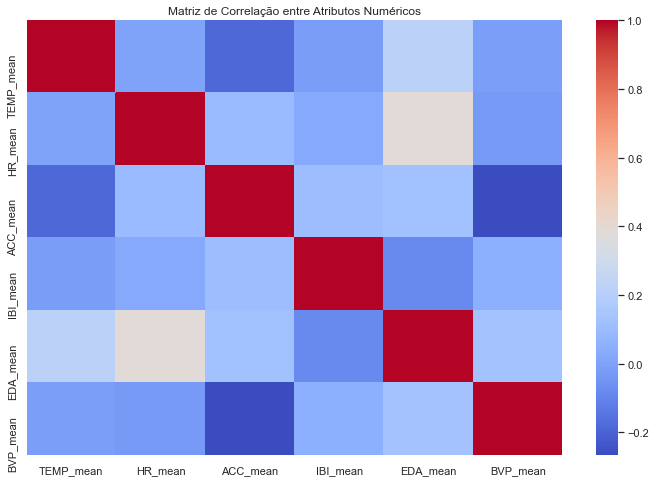


🔗 Maiores correlações encontradas:


HR_mean    EDA_mean    0.389513
ACC_mean   BVP_mean   -0.266884
TEMP_mean  EDA_mean    0.221162
           ACC_mean   -0.183606
EDA_mean   BVP_mean    0.130994
ACC_mean   EDA_mean    0.126288
           IBI_mean    0.109164
HR_mean    ACC_mean    0.094869
IBI_mean   EDA_mean   -0.079234
           BVP_mean    0.048507
dtype: float64

In [70]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Correlação entre atributos
# ==========================================================
correlacao_atributos(df)



--- Pairplot com 75 amostras e 5 atributos ---


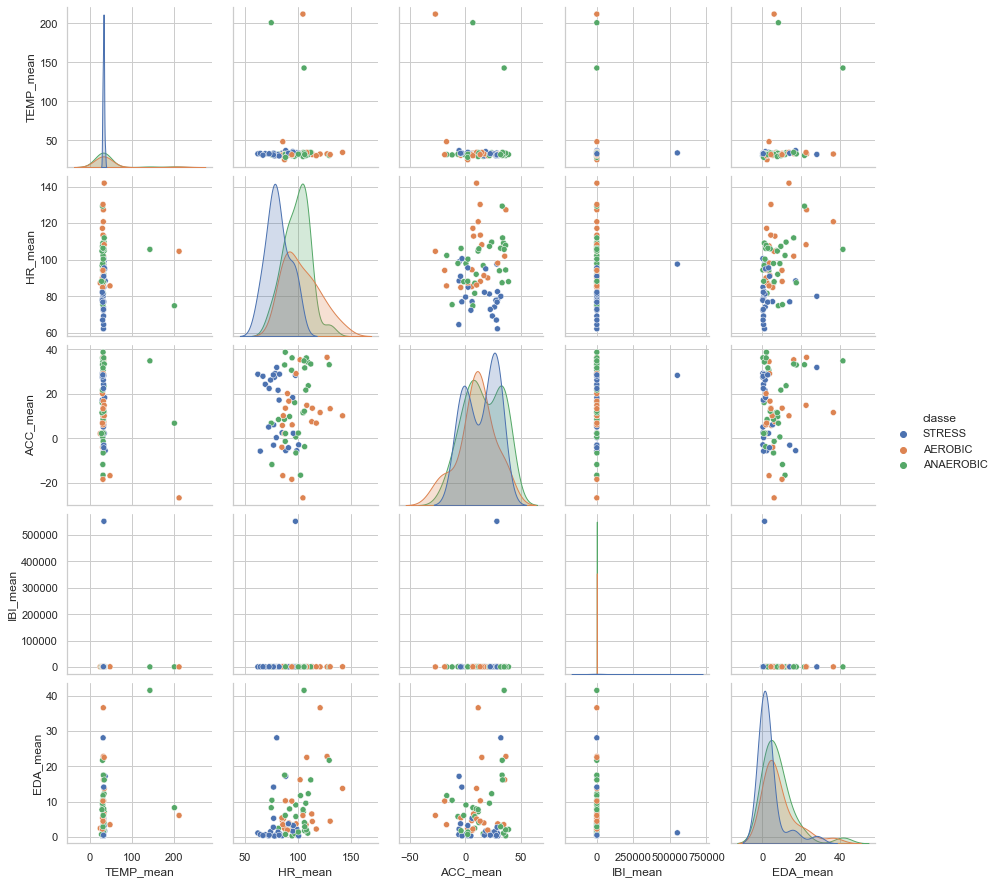

In [71]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Pairplot amostrado
# ==========================================================
pairplot_amostrado(df, n_amostras=300)


---
### Pré-processamento

Nesta seção, as funções da etapa de pré-processamento dos dados devem ser implementadas e aplicadas (se necessário).

In [72]:
# ============================================================
# ETAPA 1 — PRÉ-PROCESSAMENTO 
# ============================================================

from scripts.preprocessamento import *

# 2️⃣ Aplica as etapas de limpeza e normalização
df_train = tratar_valores_ausentes(df_train)
df_train = remover_outliers(df_train)
# df_train = remover_outliers_IQR(df_train)
df_train_nao_norm = df_train.copy()  # Cópia antes da normalização
df_train = normalizar_dados(df_train)

print(df_train.head())



--- Tratando valores ausentes ---

--- Removendo outliers ---
Removidos 0 amostras com outliers.

--- Normalizando atributos numéricos ---
        Id     classe  TEMP_mean   HR_mean  ACC_mean  IBI_mean  EDA_mean  \
0  U_79201     STRESS   1.195546  0.360740 -1.316355 -0.203643 -0.554711   
1  U_56491  ANAEROBIC  -2.617281 -0.337405 -0.799187  0.599671 -0.809173   
2  U_94628  ANAEROBIC   0.984079  0.828238 -0.129967  1.011605 -0.238148   
3  U_97819    AEROBIC  -0.938543 -0.561302 -1.212706  1.061670 -0.015199   
4  U_96956     STRESS  -0.487931 -0.905499 -0.924154  1.240926 -0.813346   

   BVP_mean  classe_cod  
0  1.491057    1.165180  
1  1.585116   -0.118493  
2  0.532417   -0.118493  
3  2.281486   -1.402166  
4 -0.190883    1.165180  


In [73]:
# Normalizar e tratar com base na analise exploratória

In [74]:
# Preparar dados de teste
df_test = gerar_dataset_teste(base_path)  # <- se quiser, crie uma versão gerar_dataset_teste()
df_test = tratar_valores_ausentes(df_test)
df_test_nao_norm = df_test.copy()  # Cópia antes da normalização
df_test = normalizar_dados(df_test)


--- Gerando dataset de TESTE ---
Dataset de TESTE com 25 amostras e 34 atributos.

--- Tratando valores ausentes ---

--- Normalizando atributos numéricos ---


---
### Experimento

Nesta seção, o experimento deve ser conduzido, utilizando os protocolos experimentais padrões e testando diferentes modelos.

In [75]:
from scripts.experimentos import *

# Prepara treino e teste diretamente
X_train, y_train, X_test, test_ids, encoder = preparar_dados(df_train, df_test)
X_train2, y_train2, X_test2, test_ids2, encoder2 = preparar_dados(df_train_nao_norm, df_test_nao_norm)


--- Preparando dados de treino e teste ---
Treino: (65, 6), Teste: (25, 6)

--- Preparando dados de treino e teste ---
Treino: (65, 6), Teste: (25, 6)


In [76]:
# --- Modelo 1: KNN ---
modelo_knn = treinar_knn(X_train, y_train, k=7)
avaliar_modelo(modelo_knn, X_train, y_train, dataset_name="Treino (KNN)")
gerar_submissao(modelo_knn, X_test, test_ids, nome_arquivo="submission_knn.csv")


--- Treinando modelo KNN (k=7) ---

--- Avaliando modelo no conjunto de Treino (KNN) ---
Acurácia: 0.6769

Matriz de Confusão:
[[10  5  2]
 [ 5 19  1]
 [ 0  8 15]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.67      0.59      0.62        17
           1       0.59      0.76      0.67        25
           2       0.83      0.65      0.73        23

    accuracy                           0.68        65
   macro avg       0.70      0.67      0.67        65
weighted avg       0.70      0.68      0.68        65


--- Gerando arquivo de submissão ---


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,0.285714,0.285714,0.428571
1,U_54670,0.285714,0.571429,0.142857
2,U_21920,0.285714,0.285714,0.428571
3,U_58128,0.285714,0.142857,0.571429
4,U_73365,0.285714,0.571429,0.142857


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,0.285714,0.285714,0.428571
1,U_54670,0.285714,0.571429,0.142857
2,U_21920,0.285714,0.285714,0.428571
3,U_58128,0.285714,0.142857,0.571429
4,U_73365,0.285714,0.571429,0.142857
5,U_89682,0.142857,0.428571,0.428571
6,U_11501,0.285714,0.285714,0.428571
7,U_46423,0.428571,0.000000,0.571429
8,U_71408,0.142857,0.000000,0.857143
9,U_95655,0.285714,0.428571,0.285714


In [77]:
# --- Modelo 2: Naive Bayes ---
modelo_nb = treinar_naive_bayes(X_train2, y_train2)
avaliar_modelo(modelo_nb, X_train2, y_train2, dataset_name="Treino (Naive Bayes)")
gerar_submissao(modelo_nb, X_test2, test_ids2, nome_arquivo="submission_naivebayes.csv")


--- Treinando modelo Naive Bayes (gaussian) ---

--- Avaliando modelo no conjunto de Treino (Naive Bayes) ---
Acurácia: 0.6462

Matriz de Confusão:
[[ 7  6  4]
 [ 5 17  3]
 [ 1  4 18]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.54      0.41      0.47        17
           1       0.63      0.68      0.65        25
           2       0.72      0.78      0.75        23

    accuracy                           0.65        65
   macro avg       0.63      0.62      0.62        65
weighted avg       0.64      0.65      0.64        65


--- Gerando arquivo de submissão ---


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,1.0,0.0,0.0
1,U_54670,1.0,0.0,0.0
2,U_21920,1.0,0.0,0.0
3,U_58128,1.0,0.0,0.0
4,U_73365,1.0,0.0,0.0


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,1.0,0.0,0.0
1,U_54670,1.0,0.0,0.0
2,U_21920,1.0,0.0,0.0
3,U_58128,1.0,0.0,0.0
4,U_73365,1.0,0.0,0.0
5,U_89682,1.0,0.0,0.0
6,U_11501,1.0,0.0,0.0
7,U_46423,1.0,0.0,0.0
8,U_71408,1.0,0.0,0.0
9,U_95655,1.0,0.0,0.0


In [78]:
# --- Modelo 3: Regressao Logistica ---
modelo_rl = treinar_regressao_logistica(X_train, y_train)
avaliar_modelo(modelo_rl, X_train, y_train, dataset_name="Treino (Regressao Logistica)")
gerar_submissao(modelo_rl, X_test, test_ids, nome_arquivo="submission_regressaolog.csv")


--- Treinando modelo de Regressão Logística ---

--- Avaliando modelo no conjunto de Treino (Regressao Logistica) ---
Acurácia: 0.7077

Matriz de Confusão:
[[ 4 10  3]
 [ 4 19  2]
 [ 0  0 23]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      0.24      0.32        17
           1       0.66      0.76      0.70        25
           2       0.82      1.00      0.90        23

    accuracy                           0.71        65
   macro avg       0.66      0.67      0.64        65
weighted avg       0.67      0.71      0.67        65


--- Gerando arquivo de submissão ---


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,0.030070,0.047703,0.922227
1,U_54670,0.318596,0.265010,0.416394
2,U_21920,0.170893,0.444199,0.384908
3,U_58128,0.575236,0.327058,0.097705
4,U_73365,0.355062,0.641044,0.003894


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,0.030070,0.047703,0.922227
1,U_54670,0.318596,0.265010,0.416394
2,U_21920,0.170893,0.444199,0.384908
3,U_58128,0.575236,0.327058,0.097705
4,U_73365,0.355062,0.641044,0.003894
5,U_89682,0.062360,0.240427,0.697213
6,U_11501,0.206071,0.396784,0.397145
7,U_46423,0.141784,0.162738,0.695477
8,U_71408,0.084827,0.119525,0.795648
9,U_95655,0.213312,0.504517,0.282171


In [79]:
# --- Modelo 4: Rede Neural ---
modelo_rn = treinar_rede_neural(X_train, y_train)
avaliar_modelo(modelo_rn, X_train, y_train, dataset_name="Treino (Rede Neural)")
gerar_submissao(modelo_rn, X_test, test_ids, nome_arquivo="submission_redeneural.csv")


--- Treinando Rede Neural Artificial ---

--- Avaliando modelo no conjunto de Treino (Rede Neural) ---
Acurácia: 1.0000

Matriz de Confusão:
[[17  0  0]
 [ 0 25  0]
 [ 0  0 23]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        23

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65


--- Gerando arquivo de submissão ---


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,0.000389,0.002533,0.997078
1,U_54670,0.166275,0.822218,0.011506
2,U_21920,0.008313,0.000117,0.991569
3,U_58128,0.013448,0.001772,0.984779
4,U_73365,0.973050,0.026949,0.000001


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,3.894223e-04,0.002533,9.970779e-01
1,U_54670,1.662754e-01,0.822218,1.150636e-02
2,U_21920,8.313316e-03,0.000117,9.915694e-01
3,U_58128,1.344842e-02,0.001772,9.847793e-01
4,U_73365,9.730503e-01,0.026949,1.110240e-06
5,U_89682,9.043801e-09,0.000047,9.999525e-01
6,U_11501,2.209949e-02,0.826732,1.511689e-01
7,U_46423,7.915338e-01,0.019987,1.884789e-01
8,U_71408,2.588247e-05,0.000068,9.999060e-01
9,U_95655,2.580121e-02,0.941921,3.227819e-02


In [80]:
# --- Modelo 5: SVM ---
modelo_svm = treinar_svm(X_train, y_train)
avaliar_modelo(modelo_svm, X_train, y_train, dataset_name="Treino (SVM)")
gerar_submissao(modelo_svm, X_test, test_ids, nome_arquivo="submission_svm.csv")


--- Treinando Máquina de Vetores de Suporte (SVM) ---

--- Avaliando modelo no conjunto de Treino (SVM) ---
Acurácia: 0.8154

Matriz de Confusão:
[[ 6 11  0]
 [ 0 24  1]
 [ 0  0 23]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.35      0.52        17
           1       0.69      0.96      0.80        25
           2       0.96      1.00      0.98        23

    accuracy                           0.82        65
   macro avg       0.88      0.77      0.77        65
weighted avg       0.86      0.82      0.79        65


--- Gerando arquivo de submissão ---


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,0.226397,0.206087,0.567516
1,U_54670,0.361881,0.397081,0.241038
2,U_21920,0.192934,0.250751,0.556315
3,U_58128,0.183889,0.216279,0.599832
4,U_73365,0.401266,0.587695,0.011039


,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,0.226397,0.206087,0.567516
1,U_54670,0.361881,0.397081,0.241038
2,U_21920,0.192934,0.250751,0.556315
3,U_58128,0.183889,0.216279,0.599832
4,U_73365,0.401266,0.587695,0.011039
5,U_89682,0.111085,0.116216,0.772698
6,U_11501,0.348006,0.455142,0.196852
7,U_46423,0.250932,0.250745,0.498323
8,U_71408,0.080400,0.061554,0.858046
9,U_95655,0.364384,0.497764,0.137852


---
### Análise dos Resultados

Nesta seção, os resultados devem ser exibidos através de tabelas e gráficos, comparados e profundamente analisados.

In [ ]:
# =========================
# AVALIAÇÃO RESUMIDA
# =========================
from scripts.analise_resultados import *

# supondo que 'modelos' seja um dict: {'knn':modelo_knn, 'naive_bayes':modelo_nb, ...}
# e que você tenha um conjunto de validação (X_val, y_val)
# Exemplo: X_val, y_val podem vir do train_test_split no seu pipeline
# !!!Esqueci de incluir a divisão de validação: from sklearn.model_selection import train_test_split

modelos = {
    "KNN": modelo_knn,
    "Naive Bayes": modelo_nb,
    "Regressão Logística": modelo_rl,
    "Rede Neural": modelo_rn,
    "SVM": modelo_svm
}

df_metrics = avaliar_modelos_dict(modelos, X_val, y_val)
display(df_metrics)

# Salvar resumo (opcional)
salvar_resumo_csv(df_metrics, path="dataset/resultados_summary.csv")


NameError: name 'modelo_log' is not defined

In [ ]:
# =========================
# CLASSIFICATION REPORTS
# =========================
mostrar_classification_reports(modelos, X_val, y_val)


In [ ]:
# =========================
# PLOT COMPARATIVO (accuracy, f1)
# =========================
plot_metric_bars(df_metrics, metrics=("accuracy", "f1_macro"))


In [ ]:
# =========================
# MATRIZ DE CONFUSÃO - modelo específico
# =========================
# exemplo: modelo 'svm'
plot_confusion_matrix_model(modelos['svm'], X_val, y_val, labels=[0,1,2], normalize=False)
# normalize=True para ver proporções ao inves de contagens


In [ ]:
# =========================
# MÉTRICAS POR CLASSE
# =========================
df_classe_knn = tabela_por_classe(modelos['knn'], X_val, y_val, labels=[0,1,2])
display(df_classe_knn)


In [ ]:
# =========================
# GRID DE MATRIZES DE CONFUSÃO PARA TODOS OS MODELOS
# =========================
comparar_modelos_plot_confusao(modelos, X_val, y_val, labels=[0,1,2], max_per_row=2, normalize=True)
